In [1]:
# Some snippets taken from Google tutorial:
# https://colab.research.google.com/github/google/eng-edu/blob/master/ml/pc/exercises/image_classification_part1.ipynb#scrollTo=H4XHh2xSfgie
from __future__ import print_function, division
import os
import torch
import random
from torchvision.transforms import ToTensor, ToPILImage
import zipfile
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import RandomSampler, Sampler
from torchvision import transforms, utils
import torch.nn as nn
from tqdm import tqdm
from typing import Iterator, List, Callable, Tuple
from functools import partial
from math import *
from IPython.display import HTML

from matplotlib import rc, cm
rc('animation', html='jshtml')

from mpl_toolkits import mplot3d
import matplotlib.animation as animation
import torchvision.models as models
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from random import sample

from IPython.core.debugger import set_trace
from tqdm import tqdm

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

#plt.ion()   # interactive mode
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import cv2
import cv2 as cv
import string
import os
from copy import deepcopy

from google.colab.patches import cv2_imshow
from collections import Counter

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
root_dir = "/content/drive/MyDrive"
project_folder = "/Datasets Captcha"

def create_and_set_working_directory(project_folder):
  if os.path.isdir(root_dir+project_folder) == False:
    # os.mkdir(root_dir+project_folder)
    print("folder doesnt exist")
  
  os.chdir(root_dir+project_folder)

create_and_set_working_directory(project_folder)

In [4]:
RANDOM_STATE = 2203
captcha_array = np.load('samir_captcha_array.npy')
captcha_labels = np.load('samir_captcha_labels.npy')

data = torch.from_numpy(captcha_array)
labels = captcha_labels

class MyDataset(Dataset):
 
  def __init__(self, data, labels):

    self.x = data
    self.y = labels
 
  def __len__(self):
    return len(self.y)
   
  def __getitem__(self,idx):
    return self.x[idx], self.y[idx]

dataset = MyDataset(data,labels)



In [5]:
BG_IDENTIFIER_CONSTANT = 50

class BackgroundColorDetector():
    def __init__(self, img):
        self.img = img
        self.manual_count = {}
        self.w, self.h, self.channels = self.img.shape
        self.total_pixels = self.w*self.h

    def count(self):
        for y in range(0, self.h):
            for x in range(0, self.w):
                RGB = (self.img[x, y, 2], self.img[x, y, 1], self.img[x, y, 0])
                if RGB in self.manual_count:
                    self.manual_count[RGB] += 1
                else:
                    self.manual_count[RGB] = 1

    def most_common(self):
        self.count()
        self.number_counter = Counter(self.manual_count).most_common(1)
        return self.number_counter[0][0]


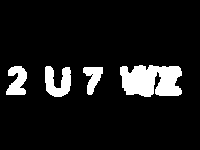

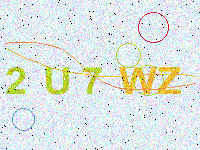

22HYS


In [7]:
def invert_image(image):
    return cv.bitwise_not(image)

def preprocess_image(img):
    BackgroundDetector = BackgroundColorDetector(img)
    avg = sum(BackgroundDetector.most_common()) // 3

    if avg > BG_IDENTIFIER_CONSTANT:
      img = invert_image(img)
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    noiseless_image_bw = cv2.fastNlMeansDenoising(gray, None, 20, 7, 21) 

    noiseless_image_bw[noiseless_image_bw < 30] = 0
    noiseless_image_bw[noiseless_image_bw > 30] = 255

    thresh = cv.threshold(noiseless_image_bw,1, 255, cv.THRESH_BINARY|cv.THRESH_OTSU)[1]

    kernel = np.ones((3, 3), np.uint8)
    morph_img = cv.erode(thresh, kernel)

    kernel = np.ones((4, 4), np.uint8)
    morph_img = cv.dilate(morph_img, kernel)

    return morph_img


def contours_to_rectangles(contours):
    letter_image_regions = []

    for contour in contours:

        (x,y,w,h) = cv2.boundingRect(contour)

        if w*h < 200 :
          continue

        letter_image_regions.append((x,y,w,h))
          
        
    return letter_image_regions


def contour_letters(image):
  image_without_noise = preprocess_image(image)
  contours = cv2.findContours(image_without_noise.copy(),cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)[0]
  letter_image_regions = contours_to_rectangles(contours)

  coppied_image = image.copy()
  for rect in letter_image_regions:
      x1,y1,x2,y2 = rect
      cv.rectangle(coppied_image,rect,(0,205,0),1)
  return coppied_image


my_img = captcha_array[:100][-7]
preprocessed_captcha = preprocess_image(my_img)
cv2_imshow(preprocessed_captcha)
cv2_imshow(my_img)
print(captcha_labels[1])

In [9]:
characters_dict = {}


def extract_letters(image):

  FIXED_WIDTH = 50
  FIXED_HEIGHT = 50

  def cmp(x):
      return x[0]

  def expand2square(pil_img, background_color):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new(pil_img.mode, (width, width), background_color)
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    else:
        result = Image.new(pil_img.mode, (height, height), background_color)
        result.paste(pil_img, ((height - width) // 2, 0))
        return result

  image_without_noise = preprocess_image(image)
  contours = cv2.findContours(image_without_noise.copy(),cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)[0]

  letter_image_regions = contours_to_rectangles(contours)
  letter_image_regions.sort(key=cmp)

  coppied_image = image.copy()
  characters = []

  for rect in letter_image_regions[:4]:
      x,y,w,h = rect
      ch_cropped = image[y:y+h,x:x+w]

      pillowed = Image.fromarray(np.uint8(ch_cropped))
      size=(50,50)
      pillowed = expand2square(pillowed, (255, 255, 255)).resize(size)
      processed_ch = np.array(pillowed)

      characters.append(processed_ch)
  return characters

for image_idx in range(len(captcha_array)):
  image = captcha_array[image_idx]
  label = captcha_labels[image_idx]

  characters = extract_letters(image)
  if len(characters) == 0:
    continue

  for c_idx in range(min(4,len(characters))):
    character_image = characters[c_idx]
    character_label = label[c_idx]

    if character_label not in characters_dict:
      characters_dict[character_label] = [character_image]
    else:
      characters_dict[character_label].append(character_image)
    

In [17]:
print(keys)

['2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'j', 'k', 'm', 'n', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [68]:

num_cls = len(characters_dict)
lr = 0.01
momentum = 0.80
num_epochs = 10
batch_size = 64


In [69]:
from sklearn.model_selection import train_test_split


keys = sorted(list(characters_dict.keys()))
characters = []
characters_labels = []

for c in keys:
  for im in characters_dict[c]:
    characters.append(np.transpose(im,(2,0,1)))
    characters_labels.append(keys.index(c))

characters = torch.from_numpy(np.array(characters,dtype=np.float32))
characters_labels = torch.from_numpy(np.array(characters_labels,dtype=np.int64))

characters_dataset = np.array(MyDataset(characters,characters_labels))

X_train, X_val, y_train, y_val = train_test_split(characters_dataset[:,0], characters_dataset[:,1], test_size=0.2, shuffle=True,random_state=RANDOM_STATE)

train_dataset = MyDataset(X_train, y_train)
validation_dataset = MyDataset(X_val, y_val)

train_dataloader = DataLoader(
    dataset=train_dataset, 
    batch_size=batch_size,
    shuffle=True
)
validation_dataloader = DataLoader(
    dataset=validation_dataset, 
    batch_size=batch_size
)

In [70]:
class SimpleConvNet(nn.Module):
    def __init__(self, out_size):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=8,kernel_size=5,stride=1)
        self.conv2 = nn.Conv2d(in_channels=8,out_channels=16,kernel_size=5,stride=1)
        self.fc1=nn.Linear(in_features=1296,out_features=128)
        self.fc2=nn.Linear(in_features=128,out_features=64)
        self.fc3=nn.Linear(in_features=64,out_features=out_size)
        self.activation_fn=nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)

        
        # TODO


    def forward(self, x):
        x = self.activation_fn(self.conv1(x))
        x = self.pool1(x)
        x = self.activation_fn(self.conv2(x))
        x = self.pool1(x)
        x = x.view(x.shape[0],-1)
        x = self.activation_fn(self.fc1(x))
        x = self.activation_fn(self.fc2(x))
        x = self.fc3(x)
        return x


net = SimpleConvNet(out_size=num_cls)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = net.to(device)

In [71]:
num_params = 0
print("Model's parameters: ")
for n, p in net.named_parameters():
    print('\t', n, ': ', p.size())
    num_params += p.numel()
print("Number of model parameters: ", num_params)

Model's parameters: 
	 conv1.weight :  torch.Size([8, 3, 5, 5])
	 conv1.bias :  torch.Size([8])
	 conv2.weight :  torch.Size([16, 8, 5, 5])
	 conv2.bias :  torch.Size([16])
	 fc1.weight :  torch.Size([128, 1296])
	 fc1.bias :  torch.Size([128])
	 fc2.weight :  torch.Size([64, 128])
	 fc2.bias :  torch.Size([64])
	 fc3.weight :  torch.Size([54, 64])
	 fc3.bias :  torch.Size([54])
Number of model parameters:  181606


In [72]:
def train_epoch(model, train_dataloader, loss_crt, optimizer, device):
    """
    model: Model object 
    train_dataloader: DataLoader over the training dataset
    loss_crt: loss function object
    optimizer: Optimizer object
    device: torch.device('cpu) or torch.device('cuda')

    The function returns: 
     - the epoch training loss, which is an average over the individual batch
       losses
    """
    model.train()
    epoch_loss = 0.0
    epoch_accuracy = 0.0
    num_batches = len(train_dataloader)
    
    for batch_idx, batch in tqdm(enumerate(train_dataloader)):
        # shape: batch_size x 1 x 28 x 28, batch_size x 1
        batch_img, batch_labels = batch
        
        # move data to GPU
        batch_img = batch_img.to(device)
        batch_labels = batch_labels.to(device)
        
        # initialize as zeros all the gradients of the model
        model.zero_grad()

        # get predictions from the FORWARD pass 
        # shape: batch_size x 10
        output = model(batch_img)

        loss = loss_crt(output, batch_labels.squeeze())       
        loss_scalar = loss.item()

        # BACKPROPAGATE the gradients
        loss.backward()
        # use the gradients to OPTIMISE the model
        optimizer.step()
        
        epoch_loss += loss_scalar

        pred = output.argmax(dim=1, keepdim=True)
        epoch_accuracy += pred.eq(batch_labels.view_as(pred)).float().mean().item()
        
    epoch_loss = epoch_loss/num_batches
    epoch_accuracy = 100. * epoch_accuracy/num_batches
    return epoch_loss, epoch_accuracy

def eval_epoch(model, val_dataloader, loss_crt, device):
    """
    model: Model object 
    val_dataloader: DataLoader over the validation dataset
    loss_crt: loss function object
    device: torch.device('cpu) or torch.device('cuda')

    The function returns: 
     - the epoch validation loss, which is an average over the individual batch
       losses
    """
    model.eval()
    epoch_loss = 0.0
    epoch_accuracy = 0.0
    num_batches = len(val_dataloader)
    with torch.no_grad():
        for batch_idx, batch in tqdm(enumerate(val_dataloader)):
            # shape: batch_size x 3 x 28 x 28, batch_size x 1
            batch_img, batch_labels = batch
            current_batch_size = batch_img.size(0)

            # move data to GPU
            batch_img = batch_img.to(device)
            batch_labels = batch_labels.to(device)
 
            # batch_size x 62
            output = model(batch_img)

            loss = loss_crt(output, batch_labels)
            loss_scalar = loss.item()

            epoch_loss += loss_scalar

            pred = output.argmax(dim=1, keepdim=True)
            epoch_accuracy += pred.eq(batch_labels.view_as(pred)).float().mean().item()

    epoch_loss = epoch_loss/num_batches
    epoch_accuracy = 100. * epoch_accuracy/num_batches
    return epoch_loss, epoch_accuracy

In [73]:

def check_model_parameters(model, display_layers=False):
  num_params = 0
  num_trainable_params = 0
  if display_layers==True:
    print("Model's parameters: ")
  for n, p in model.named_parameters():
      if display_layers == True:
        print('\t', n, ': ', p.size())
      num_params += p.numel()
      if p.requires_grad:
        num_trainable_params += p.numel()
  print("Number of model parameters: ", num_params)
  print("Number of trainable parameters: ", num_trainable_params)
# move the model to GPU (when available)
net.to(device)

# net = models.resnet18(pretrained=True)
# check_model_parameters(net, display_layers=False)
# net.fc = nn.Linear(in_features=512, out_features=62, bias=True)
# check_model_parameters(net, display_layers=False)


# create a SGD optimizer
optimizer = torch.optim.SGD(net.parameters(), lr=lr,momentum=momentum)

# set up loss function
loss_criterion = nn.CrossEntropyLoss()

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
for epoch in range(1, num_epochs+1):
  train_loss, train_accuracy = train_epoch(net, train_dataloader, loss_criterion, optimizer, device)
  val_loss, val_accuracy = eval_epoch(net, validation_dataloader, loss_criterion, device)
  train_losses.append(train_loss)
  val_losses.append(val_loss)
  train_accuracies.append(train_accuracy)
  val_accuracies.append(val_accuracy)
  print('\nEpoch %d'%(epoch))
  print('train loss: %10.8f, accuracy: %10.8f'%(train_loss, train_accuracy))
  print('val loss: %10.8f, accuracy: %10.8f'%(val_loss, val_accuracy))

500it [00:23, 21.11it/s]
125it [00:02, 50.79it/s]



Epoch 1
train loss: 3.10048221, accuracy: 24.38811475
val loss: 3.98750247, accuracy: 2.83750000


500it [00:24, 20.83it/s]
125it [00:02, 49.05it/s]



Epoch 2
train loss: 3.29465542, accuracy: 18.82540984
val loss: 2.20498495, accuracy: 45.63750000


500it [00:22, 22.06it/s]
125it [00:03, 32.19it/s]



Epoch 3
train loss: 1.80600570, accuracy: 56.10471312
val loss: 0.60496774, accuracy: 84.72500000


500it [00:24, 20.28it/s]
125it [00:03, 38.67it/s]



Epoch 4
train loss: 0.56846490, accuracy: 87.62064549
val loss: 0.38590112, accuracy: 92.73750000


500it [00:24, 20.83it/s]
125it [00:02, 49.95it/s]



Epoch 5
train loss: 0.31227877, accuracy: 93.82766393
val loss: 0.30342848, accuracy: 94.58750000


500it [00:23, 20.99it/s]
125it [00:02, 50.54it/s]



Epoch 6
train loss: 0.24014040, accuracy: 95.42781762
val loss: 0.32507587, accuracy: 95.03750000


500it [00:23, 21.05it/s]
125it [00:02, 49.49it/s]



Epoch 7
train loss: 0.16632865, accuracy: 96.83734632
val loss: 0.23655698, accuracy: 96.42500000


500it [00:23, 21.47it/s]
125it [00:03, 38.30it/s]



Epoch 8
train loss: 0.13963741, accuracy: 97.28063525
val loss: 0.24366965, accuracy: 96.31250000


500it [00:22, 22.29it/s]
125it [00:03, 41.11it/s]



Epoch 9
train loss: 0.12197209, accuracy: 97.56501025
val loss: 0.41632913, accuracy: 95.17500000


500it [00:23, 21.32it/s]
125it [00:02, 49.25it/s]



Epoch 10
train loss: 0.13440953, accuracy: 97.34938525
val loss: 0.28812292, accuracy: 96.18750000


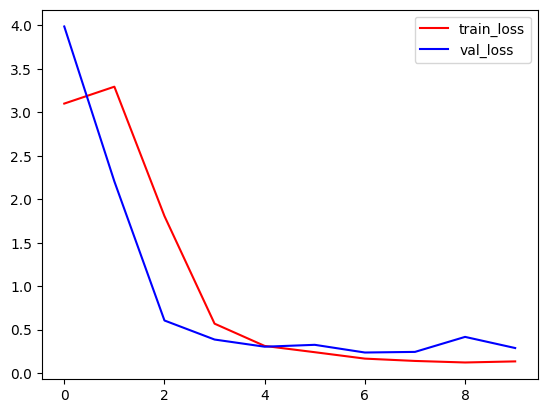

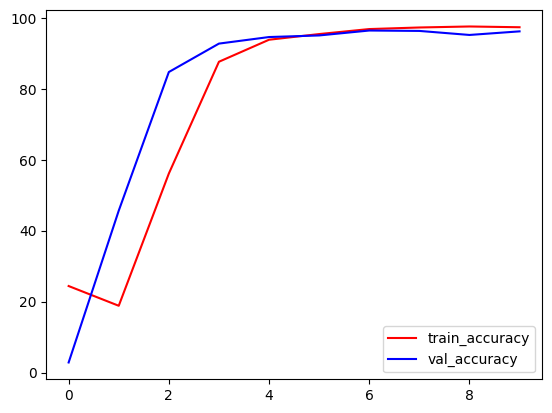

In [75]:
# plot loss & accuracy
plt.figure()
plt.plot(train_losses, label='train_loss', color='red')
plt.plot(val_losses, label='val_loss', color='blue')
plt.legend()
plt.show()
plt.plot(train_accuracies, label='train_accuracy', color='red')
plt.plot(val_accuracies, label='val_accuracy', color='blue')
plt.legend()
plt.show()